# Predicting Mortality Risk of ICU Patients Post-CABG

<span style="color:red;"><b>
MODEL BUILDING NOTEBOOK
</span></b>

## Setting up environment and loading data

In [1]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score, f1_score
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
import keras_tuner as kt
from keras_tuner import HyperParameters, RandomSearch, Objective
from tqdm.notebook import tqdm
import seaborn as sns
from keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import math

2024-12-09 11:29:47.266666: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 11:29:49.036871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 11:29:49.509253: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 11:29:49.677750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 11:29:50.705151: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Ensure reproducibility by setting random seeds
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Setting eagerly to true // https://www.tensorflow.org/api_docs/python/tf/config/run_functions_eagerly
tf.config.run_functions_eagerly(True)

In [3]:
# Set working directory
os.chdir('/sfs/gpfs/tardis/home/krb3ym/Documents/MSDS/DS6050/final_project/Predicting-Mortality-Risk-of-ICU-Patients-Post-Coronary-Artery-Bypass-Graft-Surgery/')

# Verifying GPU availability
print(tf.config.list_physical_devices('GPU'))

# Verifying tensorflow version
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.17.0


In [4]:
# Load data
directory1 = './data/final_data/chunked_complete_data/'
directory2 = './data/final_data/chunked_imputed_data/'

# List all CSV files in the directory
complete_csv_files = [os.path.join(directory1, file) for file in os.listdir(directory1) if file.endswith('.csv')]
imputed_csv_files = [os.path.join(directory2, file) for file in os.listdir(directory2) if file.endswith('.csv')]

# Read and concatenate all CSV files
complete_dfs = [pd.read_csv(csv_file) for csv_file in complete_csv_files]
imputed_dfs = [pd.read_csv(csv_file) for csv_file in imputed_csv_files]

complete_final_df = pd.concat(complete_dfs, ignore_index=True)
imputed_final_df = pd.concat(imputed_dfs, ignore_index=True)

In [5]:
complete_final_df.stay_id = complete_final_df.stay_id.astype(int).astype(str)
imputed_final_df.stay_id = imputed_final_df.stay_id.astype(int).astype(str)

complete_final_df.time_bucket = pd.to_datetime(complete_final_df.time_bucket)
imputed_final_df.time_bucket = pd.to_datetime(imputed_final_df.time_bucket)

In [6]:
pd.set_option('display.max_columns', None)
complete_final_df.head()

,stay_id,time_bucket,seq_num,anchor_age,gender,race,marital_status,insurance,vent,charlson,map,hr,pao2,fio2,creatinine,lactate,platelets,gcs,epinephrine,norepinephrine,phenylephrine,dobutamine,milrinone,dopamine,mortality
0,30004530,2165-07-31 12:00:00,1,63,M,White,DIVORCED,Medicare,0,5,73.333333,71.0,305.0,21.0,1.0,1.3,141.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,30004530,2165-07-31 13:00:00,2,63,M,White,DIVORCED,Medicare,1,5,73.333333,71.0,300.0,100.0,1.0,1.3,141.0,15.0,0.0,0.0,1.0,0.0,0.0,0.0,False
2,30004530,2165-07-31 14:00:00,3,63,M,White,DIVORCED,Medicare,1,5,70.555556,84.0,197.5,40.0,1.0,1.3,141.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,30004530,2165-07-31 15:00:00,4,63,M,White,DIVORCED,Medicare,1,5,67.777778,83.0,95.0,40.0,1.0,1.3,141.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,30004530,2165-07-31 16:00:00,5,63,M,White,DIVORCED,Medicare,1,5,65.000000,71.0,96.0,40.0,1.0,1.3,141.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,False


## Model Building

**Creating helper functions and classes for data preprocessing and model building**

In [7]:
# Creating F1 score class
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [8]:
# Create class to preprocess data
class Preprocessor:
    def __init__(self, pad_length=156, seed = 42):
        # Set global seeds
        np.random.seed(seed)
        tf.random.set_seed(seed)
        keras.utils.set_random_seed(seed)
        
        # Enable deterministic operations
        tf.config.experimental.enable_op_determinism()

        self.pad_length = pad_length
        self.label_encoders = {}
        self.numerical_scaler = StandardScaler()
        self.numerical_columns = ["anchor_age", "map", "hr", "pao2", "fio2", "gcs", "charlson",
                                "creatinine", "lactate", "platelets", "epinephrine", 
                                "norepinephrine", "phenylephrine", "dobutamine", 
                                "milrinone", "dopamine"]
        self.categorical_columns = ['insurance', 'gender', 'race', 'marital_status']
        self.binary_columns = ['vent']
        self.outcome = ['mortality']

    def fit(self, df):
        """Fit preprocessor on training data"""
        # Initialize and fit label encoders for categorical columns
        for col in self.categorical_columns:
            self.label_encoders[col] = LabelEncoder()
            self.label_encoders[col].fit(df[col].astype(str))
        
        # Fit scaler on numerical columns (reshaping for time series)
        numerical_data = df[self.numerical_columns].values
        self.numerical_scaler.fit(numerical_data)
                
        return self

    def transform(self, df):
        """Transform the data using fitted preprocessors"""
        # Transform categorical columns
        transformed_categorical = df[self.categorical_columns].copy()
        for col in self.categorical_columns:
            transformed_categorical[col] = self.label_encoders[col].transform(df[col].astype(str))

        # Stay ID
        stay_id = df['stay_id'].copy()
        
        # Scale numerical columns
        transformed_numerical = pd.DataFrame(
            self.numerical_scaler.transform(df[self.numerical_columns]),
            columns=self.numerical_columns
        )

        # Binary columns are used as-is (no transformation)
        transformed_binary = df[self.binary_columns].astype(int)
        transformed_outcome = df[self.outcome].astype(int)
        
        # Concatenate data
        transformed_data = pd.concat([stay_id, transformed_categorical, transformed_numerical, transformed_binary, transformed_outcome], axis=1)
        self.transformed_data = transformed_data
        
        # Combine transformed categorical, numerical, and binary columns
        return transformed_data

    def vectorization(self):
        """Convert transformed data to sequence vectors"""
        # Create sequences
        self.sequence_data = []
        self.sequence_labels = []
        
        for stay in self.transformed_data['stay_id'].unique():
            stay_data = self.transformed_data[self.transformed_data['stay_id'] == stay]
            features = stay_data[self.numerical_columns + self.categorical_columns + self.binary_columns].values
            label = stay_data[self.outcome].values[-1]
            
            self.sequence_data.append(features)
            self.sequence_labels.append(label)
        
        # Pad sequences
        self.sequence_data = keras.preprocessing.sequence.pad_sequences(
            self.sequence_data, 
            padding='post',
            maxlen=self.pad_length,
            value=-99
        )

        self.sequence_labels = np.array(self.sequence_labels)
        
        return self

    def train_test_split(self, size = 0.8):
        """Split data into training testing"""
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.sequence_data, self.sequence_labels, test_size=0.2, random_state=42)
        return self

    def Dataset(self, batch_size = 64):
        """Create dataset object"""
        if not hasattr(self, 'X_train'):
            raise ValueError("Must call train_test_split first")

        train_df = tf.data.Dataset.from_tensor_slices((self.X_train, self.y_train))
        train_df = (
            train_df
            .shuffle(buffer_size=len(self.X_train))        # Shuffle the entire dataset in memory
            .batch(batch_size)                        # Batch the data
            .prefetch(buffer_size=tf.data.AUTOTUNE)   # Prefetch batches for performance
        )
        
        val_df = tf.data.Dataset.from_tensor_slices((self.X_val, self.y_val))
        val_df = (
            val_df
            .batch(batch_size)                        # Batch the data
            .prefetch(buffer_size=tf.data.AUTOTUNE)   # Prefetch batches for performance
        )

        return train_df, val_df


In [9]:
# Define custom wrapper for the Keras model to use with keras tuner
class KerasModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, class_weight=None, seed = 42, max_epochs=20, max_trials=25):
        # Set global seeds
        np.random.seed(seed)
        tf.random.set_seed(seed)
        self.max_epochs = max_epochs
        self.max_trials = max_trials
        keras.utils.set_random_seed(seed)
        # Enable deterministic operations
        tf.config.experimental.enable_op_determinism()

        self.seed = seed
        self.model = None
        self.best_hp = None
        self.classes_ = np.array([0, 1])  # Binary classification
        self.tuner = None
        self.class_weight = class_weight  # Store class weights
        self.callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True)
        ]

    def create_model(self, hp, df):
        """Create the model with optional hyperparameters."""
        # Define hyperparameters
        hp_units = hp.Int('units', min_value=16, max_value=256, step = 16)
        hp_dropout = hp.Choice('dropout_rate', [0.2, 0.3, 0.4, 0.5])
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # Add seed to layer initialization
        initializer = tf.keras.initializers.GlorotUniform(seed=self.seed)

        # Extract the shape of the input data from the Dataset
        for X_batch, _ in df.take(1):
            input_shape = X_batch.shape[1:]  # Exclude the batch dimension
            break
        
        # Defining model architecture
        model = keras.Sequential([
                    keras.layers.InputLayer(shape=((input_shape[0],input_shape[1]))),
                    keras.layers.Masking(mask_value=-99),
                    layers.LSTM(hp_units, return_sequences=False, dropout=hp_dropout, kernel_initializer=initializer, recurrent_initializer=initializer),
                    keras.layers.Dense(1, activation=None, kernel_initializer=initializer)
                ])

        # Defining metrics
        metrics = [
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            AUC(name='auc'),
            AUC(name='auprc', curve='PR'),
            F1Score(name='f1_score')
        ]

        # Use binary cross-entropy with logits
        loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Compiling model
        model.compile(optimizer=Adam(learning_rate=hp_learning_rate), 
                     loss= loss_fn, 
                     metrics=metrics)
        return model

    def compute_class_weight(self, df):
        """
        Compute class weights automatically if not provided
        
        Args:
            train: TensorFlow dataset
        
        Returns:
            dict: Class weights
        """
        # Extract labels from the dataset
        #y_true = np.array([label.numpy() for _, label in df])
        y_true = np.concatenate([label.numpy().flatten() for _, label in df], axis=0)

        # Compute class distribution
        unique, counts = np.unique(y_true, return_counts=True)
        total_samples = len(y_true)
        
        # Compute balanced class weights
        class_weights = {
            0: total_samples / (2 * counts[0]),
            1: total_samples / (2 * counts[1])
        }
        
        return class_weights
    
    def tune(self, train, validation, project_name = 'LSTM_tuning'):
        """Hyperparameter fine tuning using random grid search"""
        # Automatically compute class weights if not provided
        if self.class_weight is None:
            self.class_weight = self.compute_class_weight(train)

        def build_model(hp, df = train):
            return self.create_model(hp, df = train)
        
        tuner = RandomSearch(
            build_model,
            objective=Objective("val_auprc", direction="max"),
            max_trials=self.max_trials,
            executions_per_trial=1,
            directory='models',
            project_name=project_name,
            seed = self.seed
        )
    
        tuner.search(
            train,
            validation_data=validation,
            epochs=self.max_epochs,
            callbacks=self.callbacks,
            class_weight=self.class_weight
        )
    
        # Save the best hyperparameters and model
        self.best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
        self.model = tuner.get_best_models(num_models=1)[0]
        self.tuner = tuner
    
        return self.best_hp, self.model

    def retrain_best_model(self, train, validation):
        """Retrain the best model to obtain its training history."""
        if self.best_hp is None:
            raise ValueError("No hyperparameters tuned yet. Please run tune().")

        # Automatically compute class weights if not provided
        if self.class_weight is None:
            self.class_weight = self.compute_class_weight(train)
        
        # Rebuild the best model using the best hyperparameters
        best_model = self.create_model(self.best_hp, df = train)
        if best_model is None:
            raise ValueError("Failed to create model")
        
        # Retrain the model and capture the history
        history = best_model.fit(
            train,
            epochs=self.max_epochs,
            validation_data=validation,
            callbacks=self.callbacks,
            verbose=1,
            class_weight=self.class_weight
        )
        if history is None or history.history.get('loss') is None:
            raise RuntimeError("Training failed")
        
        return best_model, history

    def predict(self, df):
        """Return predicted class labels.
        
        Args:
            df: TensorFlow dataset
        
        Returns:
            np.ndarray: Predicted class labels
        """
        if self.model is None:
            raise ValueError("No model has been trained or tuned yet.")

        logits = self.model.predict(df)  # Predict probabilities
        probabilities = tf.nn.sigmoid(logits).numpy()
        return (probabilities > 0.5).astype(int).flatten()  # Convert to binary class labels (0 or 1)
    
    def predict_proba(self, df):
        """Return probability estimates for both classes (negative and positive)"""
        if self.model is None:
            raise ValueError("No model has been trained or tuned yet.")

        logits = self.model.predict(df)  # Predict probabilities
        probabilities = tf.nn.sigmoid(logits).numpy()
        return np.hstack([1 - probabilities, probabilities])  # Class 0 and Class 1 probabilities

#### Building model on complete data

Instantiate the model wrapper, define the parameters for grid tuning, and conduct RandomizedSearchCV to tune hyperparameters

In [10]:
preprocess = Preprocessor()

# Encoding data
preprocess.fit(complete_final_df)
data = preprocess.transform(complete_final_df)

# Vectorization
preprocess.vectorization()

# Splitting train/test
preprocess.train_test_split()

# Creating datasets
train, val = preprocess.Dataset()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
2024-12-09 11:31:57.071471: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 42724 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:e3:00.0, compute capability: 8.6


In [12]:
# Initiate Wrapper
wrapper = KerasModelWrapper()
# Fine tune the model with training and validation set
best_hp, best_model = wrapper.tune(train, val, project_name= 'lstm_tuned_complete')

Trial 25 Complete [00h 01m 44s]
val_auprc: 0.2839135527610779

Best val_auprc So Far: 0.6756983399391174
Total elapsed time: 00h 24m 25s


/home/krb3ym/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
# Print best parameters
print(f"Best Hyperparameters: {best_hp.values}")
wrapper.model.summary()  # Show the best model architecture

Best Hyperparameters: {'units': 224, 'dropout_rate': 0.2, 'learning_rate': 0.01}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 156, 21)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 224)            │       220,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,641 (861.88 KB)

 Trainable params: 220,641 (861.88 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Get model metrics
best_model.evaluate(val, verbose = 0)
print(best_model.get_metrics_result())

{'accuracy': 0.9948979616165161, 'auc': 0.8873117566108704, 'auprc': 0.7859706878662109, 'f1_score': 0.7777776718139648, 'loss': 0.25695544481277466, 'precision': 0.7777777910232544, 'recall': 0.7777777910232544}


**Building model on imputed data**

In [16]:
# Fit the preprocessor on the new dataset
preprocess.fit(imputed_final_df)

# Transform the new dataset
imputed_df = preprocess.transform(imputed_final_df)

# Vectorize the transformed data
preprocess.vectorization()

# Split the data into training and validation sets
preprocess.train_test_split()

# Create the datasets for training and validation
train_imp, val_imp = preprocess.Dataset()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/krb3ym/.local/lib/python3.10/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


In [17]:
# Initiate Wrapper
imputed_wrapper = KerasModelWrapper()
# Fine tune the model with training and validation set
best_imp_hp, best_imp_model = imputed_wrapper.tune(train_imp, val_imp, project_name= 'lstm_tuned_imputed')

2024-12-08 19:13:40.671013: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Reloading Tuner from models/lstm_tuned_imputed/tuner0.json


/home/krb3ym/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [18]:
# Print best parameters
print(f"Best Hyperparameters: {best_imp_hp.values}")
imputed_wrapper.model.summary()  # Show the best model architecture

Best Hyperparameters: {'units': 16, 'dropout_rate': 0.4, 'learning_rate': 0.01}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 156, 21)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,449 (9.57 KB)

 Trainable params: 2,449 (9.57 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Get model metrics
best_imp_model.evaluate(val, verbose = 0)
print(best_imp_model.get_metrics_result())

{'accuracy': 0.9910714030265808, 'auc': 0.8822222352027893, 'auprc': 0.44508033990859985, 'f1_score': 0.5882352590560913, 'loss': 0.4046884775161743, 'precision': 0.625, 'recall': 0.5555555820465088}


## Visualization

In [23]:
# Helper functions
# Bootstrapping and calculating 95% CI
from sklearn.utils import resample
pd.set_option('display.max_rows', None)

def predict_hourly(sequences, model, max_seq_length):
    """Get predictions using truncated sequences"""
    n_patients = len(sequences)
    predictions = np.zeros((n_patients, max_seq_length))
    
    for hour in range(1, max_seq_length + 1):
        # Truncate sequences up to current hour
        truncated_sequences = sequences[:, :hour, :]
        # Pad sequences to max_seq_length if necessary
        padded_sequences = keras.preprocessing.sequence.pad_sequences(
            truncated_sequences, maxlen=max_seq_length, padding='post', value=-99)
        # Make predictions
        logits = model.predict(padded_sequences, verbose=0)[:, 0]
        predictions[:, hour - 1] = logits
        
    return predictions

def calculate_hourly_metrics(y_true, predictions, hours):
    """Calculate performance metrics for specified hours."""
    metrics_dict = {
        'hour': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'auc': [],
        'auprc': [],
        'f1_score': []
    }
    
    for hour in hours:
        hour_logits = predictions[:, hour - 1]  # Adjust index since hours start at 1
        hour_preds = 1 / (1 + np.exp(-hour_logits))
        binary_preds = (hour_preds > 0.5).astype(int)
        metrics_dict['hour'].append(hour)
        metrics_dict['accuracy'].append(accuracy_score(y_true, binary_preds))
        metrics_dict['precision'].append(precision_score(y_true, binary_preds, zero_division=0))
        metrics_dict['recall'].append(recall_score(y_true, binary_preds))
        metrics_dict['auc'].append(roc_auc_score(y_true, hour_preds))
        metrics_dict['auprc'].append(average_precision_score(y_true, hour_preds))
        metrics_dict['f1_score'].append(f1_score(y_true, binary_preds))
    
    return pd.DataFrame(metrics_dict)

def bootstrap_metrics(y_true, predictions, n_bootstraps=100, confidence_level=90, max_hours=100):
    """Calculate bootstrap confidence intervals for performance metrics over time."""
    # Define the percentiles for the confidence intervals
    lower_percentile = (100 - confidence_level) / 2
    upper_percentile = 100 - lower_percentile
    
    # Store metrics for each bootstrap iteration
    bootstrap_results = []
    n_samples = len(y_true)
    hours = range(1, max_hours + 1)
    
    for i in tqdm(range(n_bootstraps), desc='Bootstrapping'):
        # Resample with replacement
        indices = np.random.choice(n_samples, n_samples, replace=True)
        y_true_bootstrap = y_true[indices]
        predictions_bootstrap = predictions[indices, :]
        
        # Calculate metrics for this bootstrap sample
        metrics_df = calculate_hourly_metrics(y_true_bootstrap, predictions_bootstrap, hours)
        metrics_df['bootstrap_iteration'] = i
        bootstrap_results.append(metrics_df)
    
    # Combine all bootstrap results into a single DataFrame
    bootstrap_metrics_df = pd.concat(bootstrap_results)
    
    # Calculate mean and confidence intervals for each metric at each hour
    ci_metrics = []
    for hour in hours:
        hour_metrics = bootstrap_metrics_df[bootstrap_metrics_df['hour'] == hour]
        ci_dict = {'hour': hour}
        for metric in ['accuracy', 'precision', 'recall', 'auc', 'auprc', 'f1_score']:
            metric_values = hour_metrics[metric].values
            ci_dict[f'{metric}_mean'] = np.mean(metric_values)
            ci_dict[f'{metric}_lower'] = np.percentile(metric_values, lower_percentile)
            ci_dict[f'{metric}_upper'] = np.percentile(metric_values, upper_percentile)
        ci_metrics.append(ci_dict)
    
    ci_metrics_df = pd.DataFrame(ci_metrics)
    return ci_metrics_df

In [18]:
# Re-prepare sequences truncated up to the maximum hour
max_seq_length = 156  # or the maximum hour you want to evaluate
predictions = predict_hourly(preprocess.X_val, model=best_model, max_seq_length=max_seq_length)
metrics_results = calculate_hourly_metrics(y_true=preprocess.y_val, predictions=predictions, max_hours=max_seq_length)
#metrics_results

/home/krb3ym/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-12-09 11:33:21.763727: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8904


  0%|          | 0/156 [00:00<?, ?it/s]

In [20]:
# Assume you have your test set true labels and predictions
ci_metrics_df = bootstrap_metrics(preprocess.y_val, predictions, n_bootstraps=500, confidence_level=95, max_hours=156)

Bootstrapping:   0%|          | 0/500 [00:00<?, ?it/s]

In [21]:
# Rolling average:
ci_metrics_df['auc_mean_smoothed'] = ci_metrics_df['auc_mean'].rolling(window=5).mean()
ci_metrics_df['auc_lower_smoothed'] = ci_metrics_df['auc_lower'].rolling(window=5).mean()
ci_metrics_df['auc_upper_smoothed'] = ci_metrics_df['auc_upper'].rolling(window=5).mean()

ci_metrics_df['accuracy_mean_smoothed'] = ci_metrics_df['accuracy_mean'].rolling(window=5).mean()
ci_metrics_df['accuracy_lower_smoothed'] = ci_metrics_df['accuracy_lower'].rolling(window=5).mean()
ci_metrics_df['accuracy_upper_smoothed'] = ci_metrics_df['accuracy_upper'].rolling(window=5).mean()

ci_metrics_df['precision_mean_smoothed'] = ci_metrics_df['precision_mean'].rolling(window=5).mean()
ci_metrics_df['precision_lower_smoothed'] = ci_metrics_df['precision_lower'].rolling(window=5).mean()
ci_metrics_df['precision_upper_smoothed'] = ci_metrics_df['precision_upper'].rolling(window=5).mean()

ci_metrics_df['recall_mean_smoothed'] = ci_metrics_df['recall_mean'].rolling(window=5).mean()
ci_metrics_df['recall_lower_smoothed'] = ci_metrics_df['recall_lower'].rolling(window=5).mean()
ci_metrics_df['recall_upper_smoothed'] = ci_metrics_df['recall_upper'].rolling(window=5).mean()

ci_metrics_df['auprc_mean_smoothed'] = ci_metrics_df['auprc_mean'].rolling(window=5).mean()
ci_metrics_df['auprc_lower_smoothed'] = ci_metrics_df['auprc_lower'].rolling(window=5).mean()
ci_metrics_df['auprc_upper_smoothed'] = ci_metrics_df['auprc_upper'].rolling(window=5).mean()

ci_metrics_df['f1_score_mean_smoothed'] = ci_metrics_df['f1_score_mean'].rolling(window=5).mean()
ci_metrics_df['f1_score_lower_smoothed'] = ci_metrics_df['f1_score_lower'].rolling(window=5).mean()
ci_metrics_df['f1_score_upper_smoothed'] = ci_metrics_df['f1_score_upper'].rolling(window=5).mean()

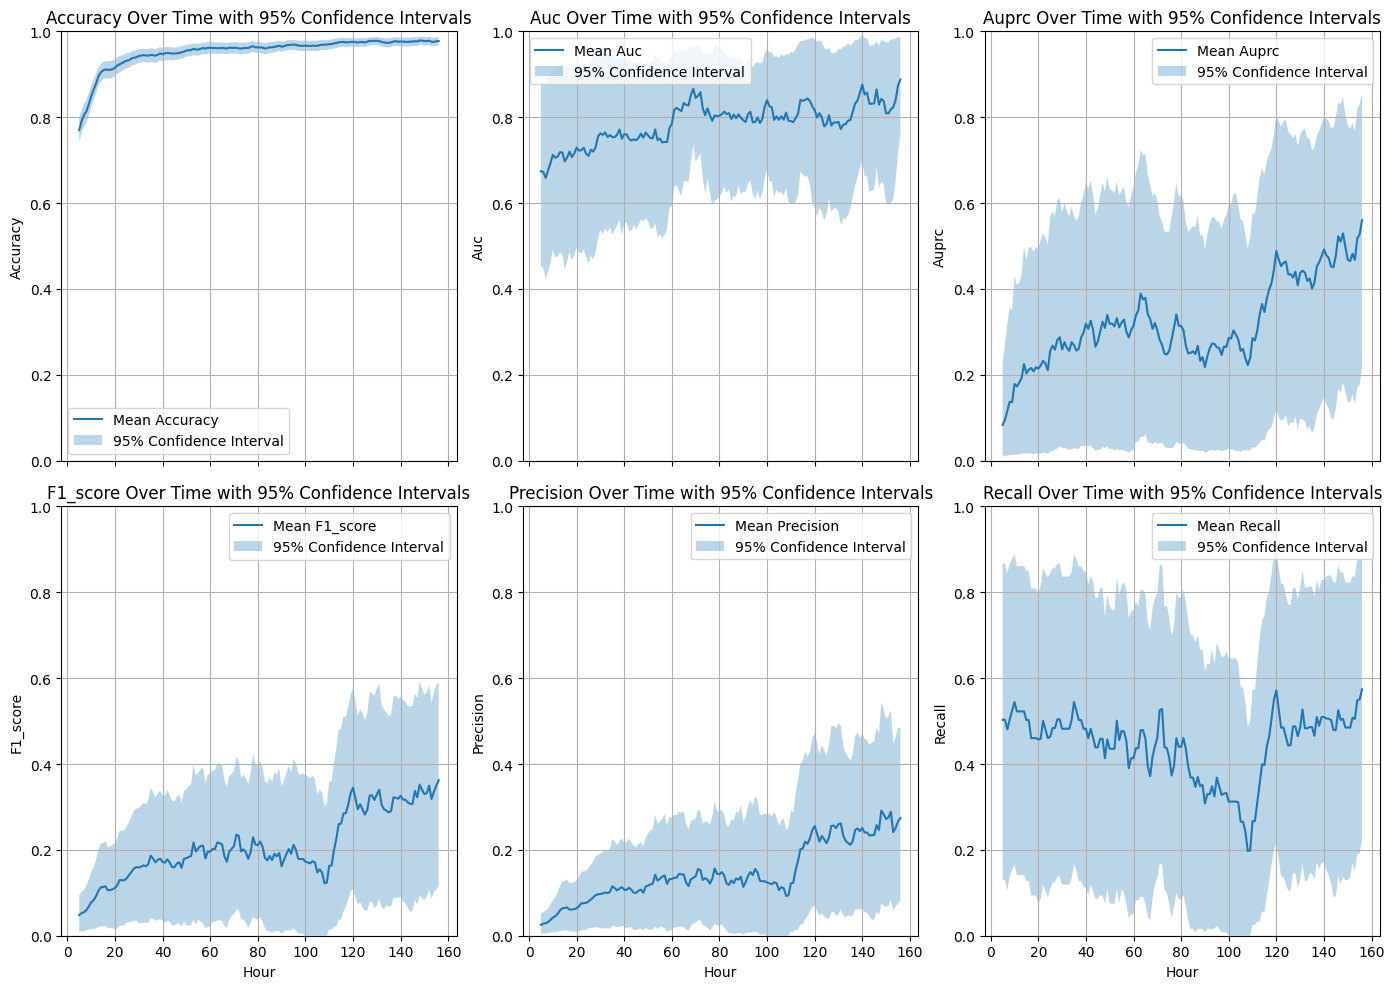

In [29]:
# Metrics to plot
metrics_to_plot = ['accuracy', 'auc', 'auprc', 'f1_score', 'precision', 'recall']

# Determine the number of rows and columns for the grid
n_metrics = len(metrics_to_plot)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(n_metrics / n_cols)  # Number of rows needed

# Create subplots with a grid pattern
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows), sharex=True)
axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array for easier indexing

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(x='hour', y=f'{metric}_mean_smoothed', data=ci_metrics_df, ax=ax, label=f'Mean {metric.capitalize()}')
    
    # Add the confidence interval
    ax.fill_between(ci_metrics_df['hour'],
                    ci_metrics_df[f'{metric}_lower_smoothed'],
                    ci_metrics_df[f'{metric}_upper_smoothed'],
                    alpha=0.3, label='95% Confidence Interval')
    
    ax.set_title(f'{metric.capitalize()} Over Time with 95% Confidence Intervals')
    ax.set_xlabel('Hour')
    ax.set_ylabel(metric.capitalize())
    ax.set_ylim(0, 1)  # Metrics are between 0 and 1
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig('visuals/cabg_lstm_metric_per_time.png')
plt.show()
